# Dota API match data EDA

This script covers the initial data exploration for feature extraction as well as tests for the engineering of the data preprocessing pipeline.

## Setup

### Imports

In [1]:
import requests
import pprint
import json
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pymongo import MongoClient

import game_data_collector.parse_game_data_utils as pgdu
import game_data_collector.api as dapi
from database import MongoDB


### Get Heroes from OpenDota API (real time)

**With Explorer API (alternatively)**  
Note: Uses PostgreSQL 9.5.10: SELECT version();  

Get heroes table columns and types:  
`SELECT column_name, data_type FROM information_schema.columns WHERE table_name = 'heroes';`  

Get all heroes:  
`SELECT * from heroes ORDER by heroes.id ASC;`

#### All heroes

In [2]:
res: requests.Response = pgdu.make_request_with_retries("https://api.opendota.com/api/heroes")
heroes: list[dict] = []
if res.status_code != 200:
    raise ValueError(f'Failed to retrieve data: {res.status_code}')
else:
    heroes = json.loads(res.text)

# print(heroes)

In [3]:
heroes_ids_roles = pd.DataFrame(heroes, columns=["id", "localized_name", "attack_type"]).set_index('id', drop=True) # 145 heroes in total
print(heroes_ids_roles)

     localized_name attack_type
id                             
1         Anti-Mage       Melee
2               Axe       Melee
3              Bane      Ranged
4       Bloodseeker       Melee
5    Crystal Maiden      Ranged
..              ...         ...
135     Dawnbreaker       Melee
136           Marci       Melee
137    Primal Beast       Melee
138          Muerta      Ranged
145             Kez       Melee

[126 rows x 2 columns]


#### Filter by role

Distinct roles are: Carry, Durable, Escape, Initiator, Disabler, Nuker, Support, Pusher (heroes can have multiple roles!)  
`SELECT DISTINCT roles from heroes;`  

Get all heroes that are flagged as 'Carry':  
`SELECT * from heroes WHERE 'Carry' = ANY(roles) ORDER by heroes.id ASC;`

Role.CANONICAL_CARRY is a custom set of predefined heroes

In [4]:
# Sample call
print(dapi.get_hero_ids_of_role(dapi.Role.CANONICAL_CARRY))

[1, 4, 6, 8, 12, 18, 41, 44, 46, 48, 54, 56, 59, 61, 67, 72, 77, 80, 81, 94, 109]


### DB Connection (to cached match data)

In [5]:
db = MongoDB(username='root', password='example')
db.connect_db()
db.get_database("mmr_predictor")
col = db.get_collection("dota_game_collection")

## Database queries (MongoDB)

In [6]:
# Sample document structure

res = col.find_one()

pprint.pprint(res)


{'_id': 7861499456,
 'dire_score': 15,
 'duration': 1521,
 'lobby_type': 7,
 'match_id': 7861499456,
 'metadata': None,
 'players': [{'abandons': 0,
              'account_id': 114547560,
              'actions_per_min': 130,
              'ancient_kills': 0,
              'assists': 21,
              'benchmarks': {'gold_per_min': {'pct': 0.5568658804717169,
                                              'raw': 382},
                             'hero_damage_per_min': {'pct': 0.5010993403957625,
                                                     'raw': 487.4950690335306},
                             'hero_healing_per_min': {'pct': 0.535078952628423,
                                                      'raw': 0},
                             'kills_per_min': {'pct': 0.3132120727563462,
                                               'raw': 0.07889546351084813},
                             'last_hits_per_min': {'pct': 0.053367979212472515,
                                            

### Unique matches and players

In [7]:
print(f"Found {col.count_documents({})} recorded matches with {len(col.distinct('players.account_id'))} unique players in the database.")

# First batch has 5180 matches and 20799 unique players of whom 18356 are in tier (11, 80)


Found 8954 recorded matches with 37319 unique players in the database.


### Match duration

In [8]:
# Query basic match duration statistics within mongo itself (a pipeline)

# Aggregation pipeline
pipeline = [
    {
        "$group": {
            "_id": None,
            "mean": { "$avg": "$duration" },
            "min": { "$min": "$duration" },
            "max": { "$max": "$duration" },
            "durations": { "$push": "$duration" }  # Collect all durations for calc
        }
    },
    {
        "$addFields": {
            "std": { #
                "$sqrt": {
                    "$avg": {
                        "$map": {   # sum?
                            "input": "$durations",
                            "as": "duration",
                            "in": {
                                "$pow": [{ "$subtract": ["$$duration", "$mean"] }, 2] # (x_i - x_avg))**2
                            }
                        }
                    }
                }
            }
        }
    },
    {
        "$project": {
            "_id": 0,  # Exclude the _id field
            "min": 1,
            "max": 1,
            "mean": 1,
            "std": 1
        }
    }
]


# Execute the aggregation pipeline
result = list(col.aggregate(pipeline))

if result:
    print(f"Match duration min={result[0]['min']/60:.1f} min, max={result[0]['max']/60:.1f} min, avg={result[0]['mean']/60:.1f} min, std={result[0]['std']/60:.1f} min")

Match duration min=25.0 min, max=66.0 min, avg=30.7 min, std=4.1 min


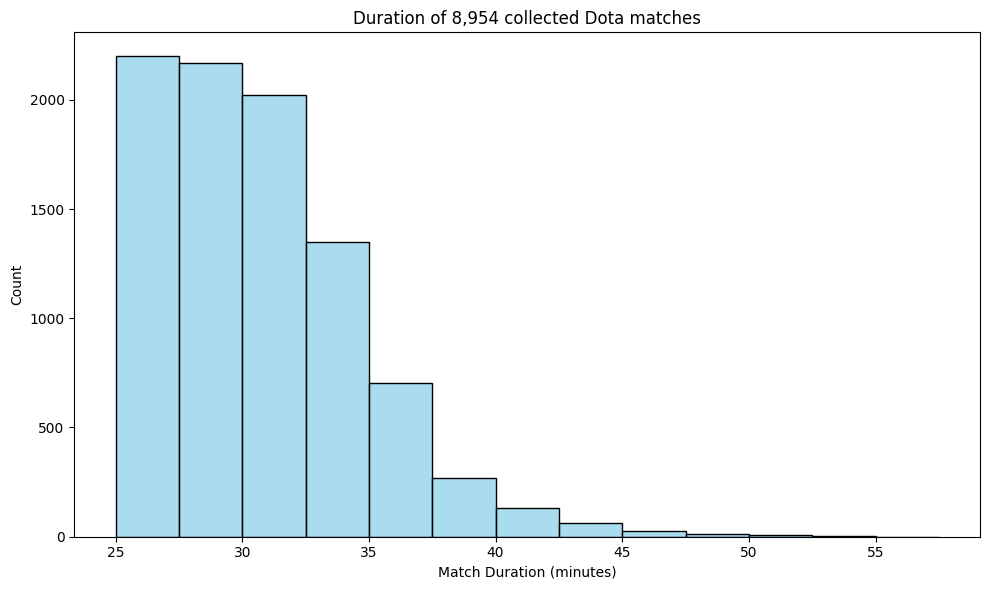

In [9]:
# Aggregation pipeline
pipeline = [
    {
        "$group": {
            "_id": None,
            "durations": { "$push": "$duration" }  # Collect all durations for calc
        }
    }
]


# Execute the aggregation pipeline
result = list(col.aggregate(pipeline))
t_min = np.array(result[0]["durations"]) / 60

# Create the histogram
plt.figure(figsize=(10, 6))

# Set the style using seaborn
# sns.set_theme(style="whitegrid")

# IMPORTANT match duration cut of is set to 25 mins in game_data_collector.validate_clean_match_data
# Define bin edges for 2.5-minute intervals from 25 to 60
bins = np.arange(25, 60, 2.5)  

# Plot histogram using sns.histplot
sns.histplot(
    t_min,
    bins=bins,
    kde=False,
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)

# Customize x-ticks to show every 5 minutes
plt.xticks(np.arange(25, 60, 5))

# Labeling x and y axis, and title
plt.xlabel('Match Duration (minutes)')
plt.ylabel('Count')
plt.title(f'Duration of {len(t_min):,} collected Dota matches')

# Enhance layout
plt.tight_layout()

# Show the plot
plt.show()


### Players Rank Tiers

#### Distinct tiers

In [10]:
# There are 5*8 Dota 2 MMR ranks: https://dota2freaks.com/ranks/
# There are 8 different tiers, with 5 levels each: Herald, Guardian, Crusader, Archon, Legend, Ancient Divine Immortal
# I think this explains the data showing (None-10) 11-15, 21-25, 31-35 etc

# IMPORTANT: Immortal (Rank 8) is "placed", and contains Top 1 to 1000 players (huge bin)

distinct_tiers = col.distinct("players.rank_tier")
print(f"Found {len(distinct_tiers)} different rank tiers: {distinct_tiers}")

Found 36 different rank tiers: [None, 12, 13, 14, 15, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 51, 52, 53, 54, 55, 61, 62, 63, 64, 65, 71, 72, 73, 74, 75, 80]


#### All players tiers as list

In [11]:
# excluding min and max
pipeline = [
    {"$unwind": "$players"}, # Unwind the players array
    {"$match": {"players.rank_tier": {"$nin": [None, 80]}}},         # Match only documents where rank_tier is not min or max
    {"$group": {"_id": None, "rank_tiers": {"$push": "$players.rank_tier"}}}, # Collect all player ranks (including duplicates)
    {"$project": {"_id": 0, "rank_tiers": 1}}              # Exclude the _id from the result
]

# just replacing None with 0
# pipeline = [
#     {"$unwind": "$players"}, # Unwind the players array
#     {"$group": {"_id": None, "rank_tiers": {"$push": {"$ifNull": ["$players.rank_tier", 0]}}}},  # replace None by 0
#     {"$project": {"_id": 0, "rank_tiers": 1}}              # Exclude the _id from the result
# ]

res = col.aggregate(pipeline)

for r in res:   # assuming there is only one result entry
    rank_tiers = r['rank_tiers']

[11, 21, 31, 41, 51, 61, 71, 81]


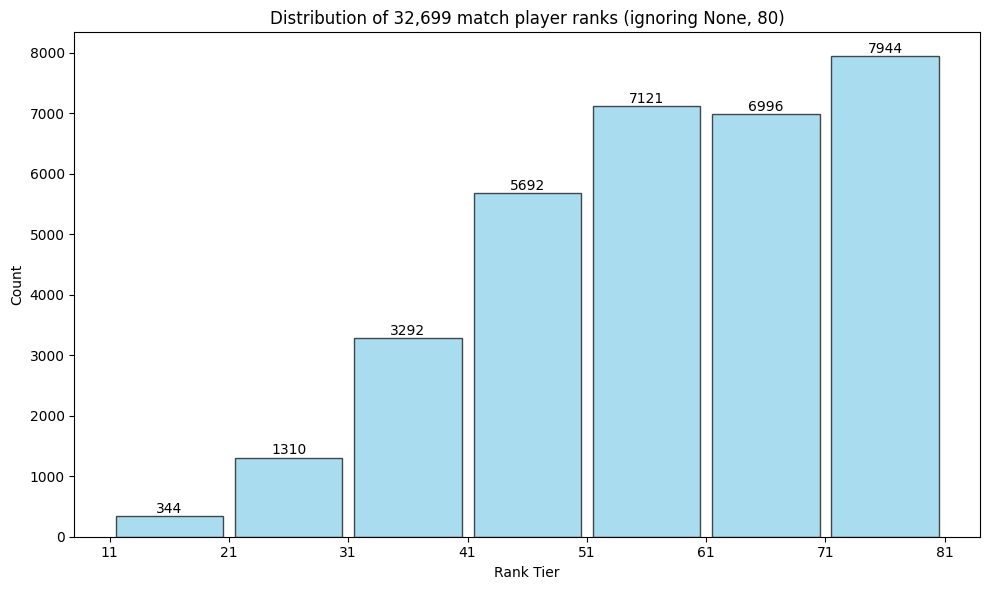

In [12]:
# Create the histogram
plt.figure(figsize=(10, 6))
bins = range(11, 91, 10)  # Bins from 0 to 80 with a width of 10
print(list(bins))

bar_width = 0.9 * (bins[1] - bins[0]) 

# Plot histogram
counts, _, patches = plt.hist(rank_tiers, bins=bins, density=False, edgecolor='black', color='skyblue', alpha=0.7, rwidth=0.9)

# Labeling x and y axis, and title
plt.xlabel('Rank Tier')
plt.ylabel('Count',)
plt.title(f'Distribution of {len(rank_tiers):,} match player ranks (ignoring None, 80)')

# Set x-ticks at intervals of 10
plt.xticks(range(11, 91, 10))

# Display counts on top of each bar
for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 50, f'{int(count)}', ha='center')

# Show the plot
plt.tight_layout()
plt.show()

### Match Feature Exploration

Currently supported KPIs are

|KPI|attr|description|supplemental|
|---|---|---|---|
|kda|kda|kill-death-assist-ratio $\frac{k+a}{d}$|[reddit](https://www.reddit.com/r/DotA2/comments/20dnc8/what_is_a_good_kda_ratio/)|
|last hit|last_hit|get final hit of a creep, hero or building||
|apm|actions_per_min|avg. control input count of player|[reddit](https://www.reddit.com/r/learndota2/comments/6f0n5a/can_somebody_explain_actions_per_minute_to_me/)|
|gpm|gold_per_min|depends on factors like match duration and last hit count of buildings|[reddit](https://www.reddit.com/r/DotA2/comments/srgpw/whats_an_average_gold_per_minute/)|
|xpm|xp_per_min|hero xp gained per match, kill xp is shared between all allies in a defined radius|[dota2 fandom](https://dota2.fandom.com/wiki/Experience)|


#### KPI correlation matrix

In [13]:
df_any = dapi.get_kpis_by_role(col, dapi.Role.ANY)
df_cc = dapi.get_kpis_by_role(col, dapi.Role.CANONICAL_CARRY)

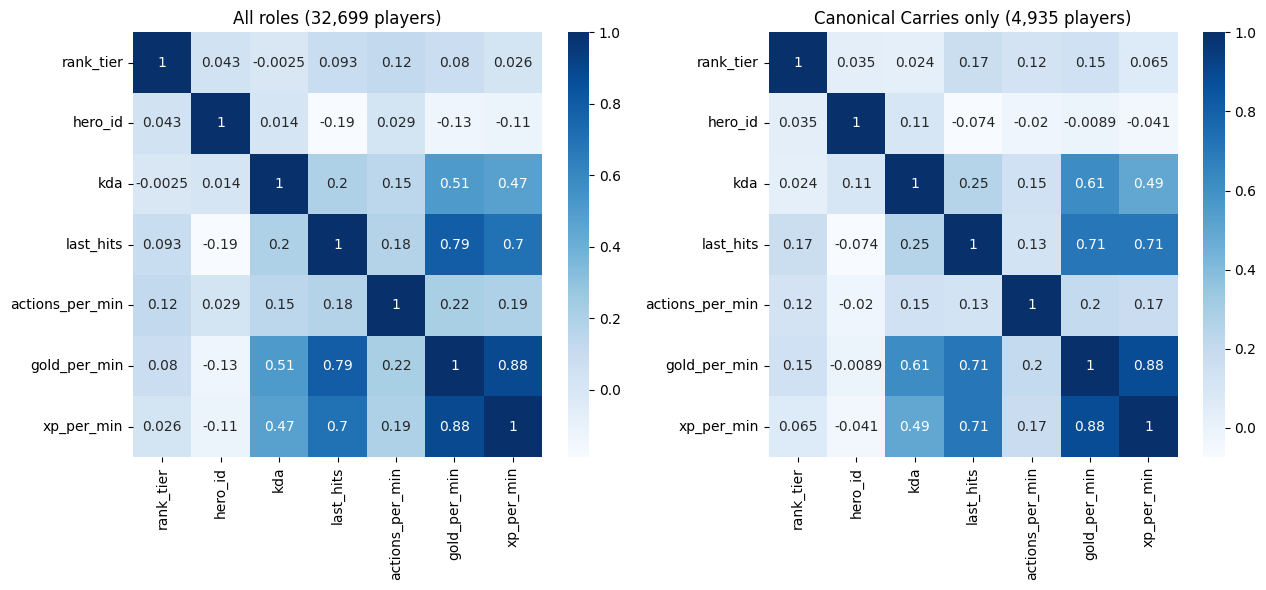

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# Compute correlation matrix for df1 and plot it on the first subplot
matrix1 = df_any.corr()
sns.heatmap(matrix1, annot=True, cmap='Blues', ax=axes[0])
axes[0].set_title(f'All roles ({len(df_any):,} players)')

# Compute correlation matrix for df2 and plot it on the second subplot
matrix2 = df_cc.corr()
sns.heatmap(matrix2, annot=True, cmap='Blues', ax=axes[1])
axes[1].set_title(f'Canonical Carries only ({len(df_cc):,} players)')

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

#### KPIs mean by role

In [15]:
# get stats summary for each role
# CAVE: One hero can have multiple roles

all_stats_mean: list[pd.Series] = []

for role in tqdm(dapi.Role):
    
    # skip
    if role == dapi.Role.ANY:
        continue
    
    df_ = dapi.get_kpis_by_role(col, role)
    df_.drop("hero_id", axis=1, inplace=True)
    role_mean = df_.mean().round(2) # get mean of all kpis
    role_mean = pd.concat([role_mean, pd.Series({"count": len(df_)})]) # add sample count
    all_stats_mean.append(role_mean.rename(role.name))
    
df_stats_mean: pd.DataFrame = pd.DataFrame(all_stats_mean)

print(df_stats_mean)

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]

                 rank_tier   kda  last_hits  actions_per_min  gold_per_min  \
CARRY                54.67  4.41     172.48           236.69        510.12   
DISABLER             54.66  3.95     117.74           226.19        435.16   
DURABLE              54.67  4.24     141.76           233.66        470.07   
ESCAPE               55.36  4.20     142.10           239.10        466.79   
INITIATOR            54.55  3.80     117.68           226.61        436.37   
NUKER                54.93  3.98     120.96           227.75        442.16   
PUSHER               54.50  4.02     159.42           231.64        485.88   
SUPPORT              54.24  3.77      83.56           216.17        389.31   
CANONICAL_CARRY      54.06  4.40     218.26           239.85        555.06   

                 xp_per_min    count  
CARRY                608.56  18708.0  
DISABLER             536.62  23981.0  
DURABLE              565.75  11991.0  
ESCAPE               573.99  12889.0  
INITIATOR            537

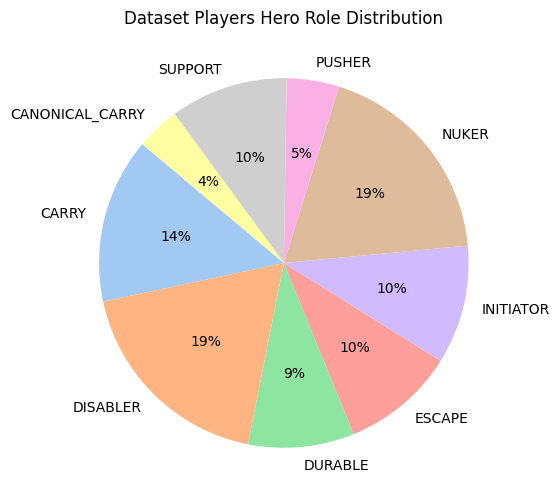

In [16]:
plt.figure(figsize=(10, 6)) 
colors = sns.color_palette('pastel')[0:len(df_stats_mean.index)]
plt.pie(df_stats_mean["count"], labels=df_stats_mean.index, colors=colors, autopct='%1.0f%%', startangle=140)
plt.title("Dataset Players Hero Role Distribution") 
# plt.legend(title="Classes") 

plt.show()

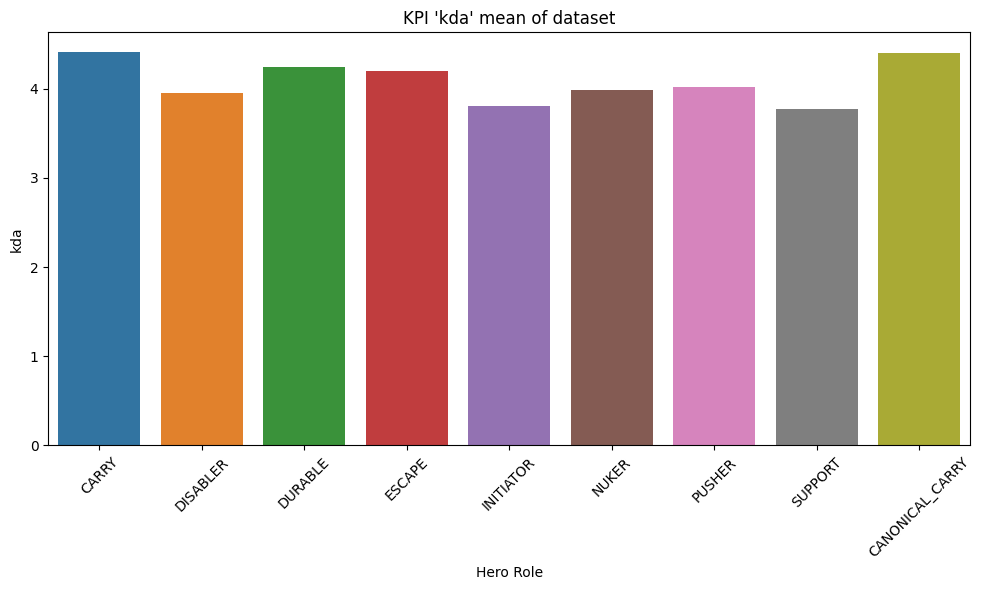

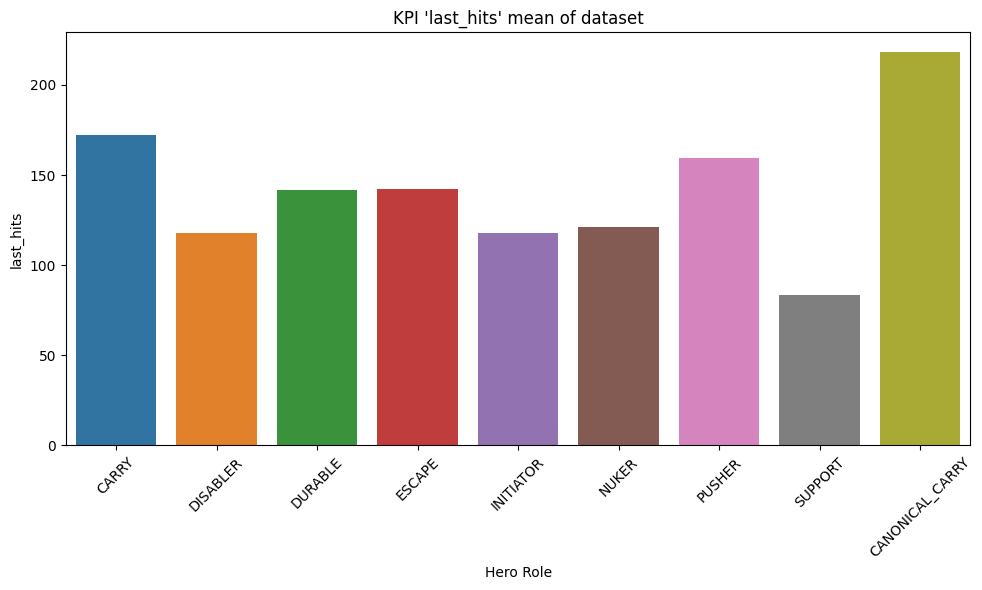

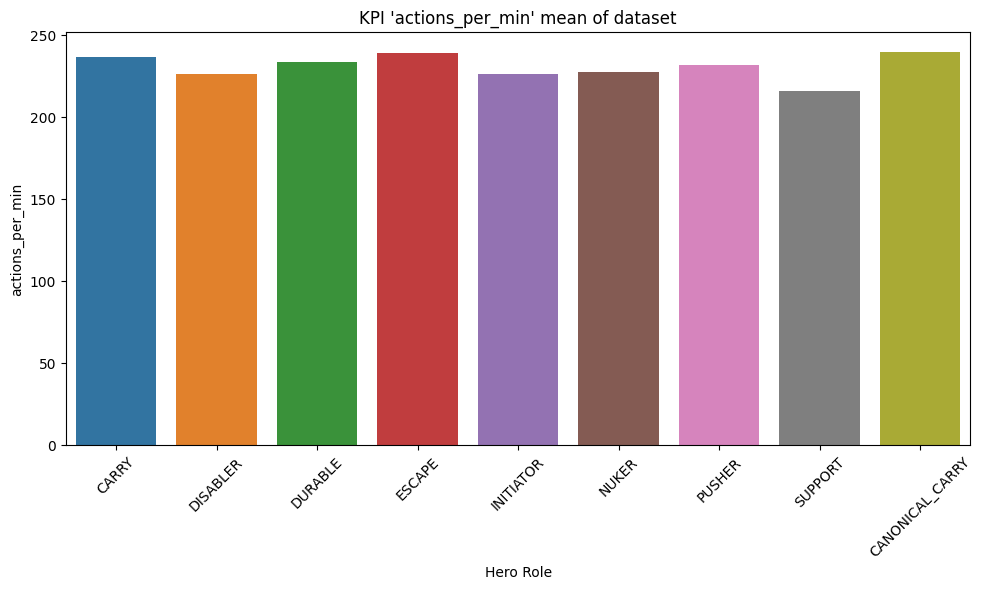

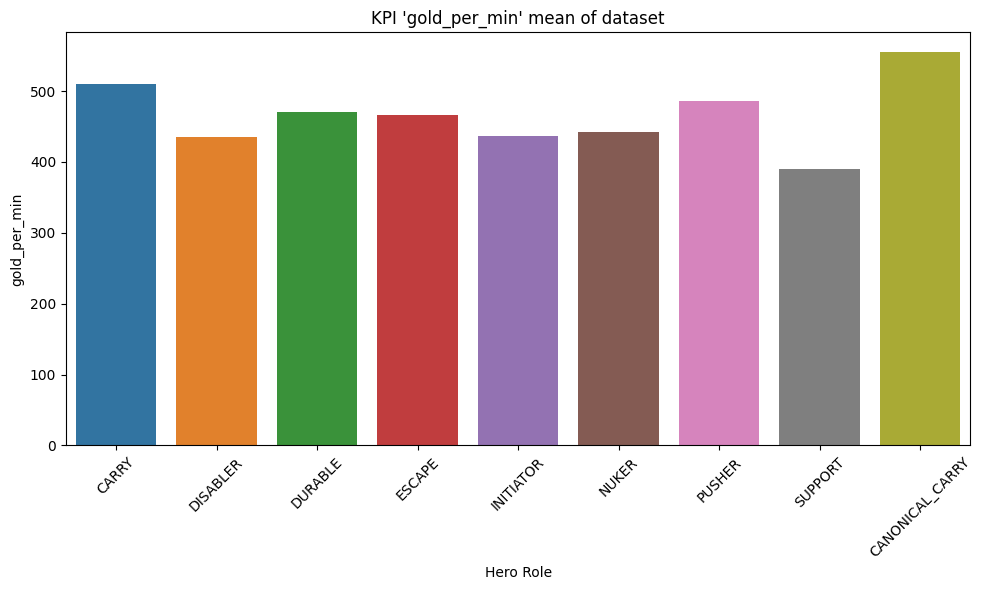

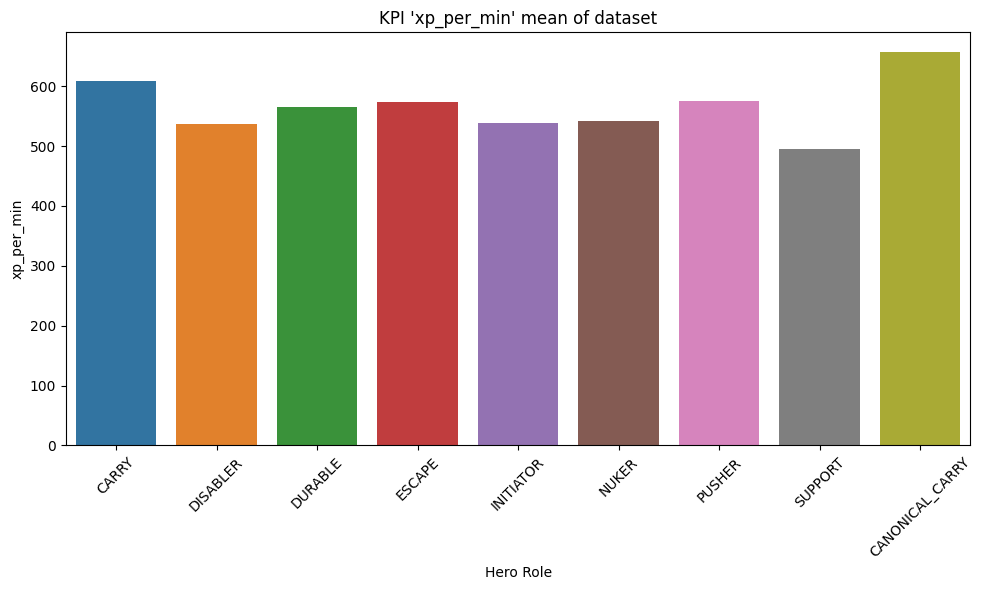

In [ ]:
variables = ["kda", "last_hits", "actions_per_min", "gold_per_min", "xp_per_min"]

for var in variables:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.barplot(x=df_stats_mean.index, y=df_stats_mean[var], ax=ax, hue=df_stats_mean.index)
    ax.set_title(f"KPI '{var}' mean of dataset")
    ax.set_xlabel('Hero Role')
    ax.set_ylabel(var)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()